# Model building

In [1]:
import pickle
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import configuration as config

## 1. Load data

In [2]:
train_df=pd.read_csv(config.TRAINING_DATAFILE)
test_df=pd.read_csv(config.TESTING_DATAFILE)

## 2. Cross-validation: model

In [3]:
def cross_val_boosting_model(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(scores)
    return X_train, y_train, y_test, y_pred

hist_boost_model = HistGradientBoostingClassifier(random_state=42)
X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', hist_boost_model)

[0.99622041 0.99712917 0.99667476 0.99721175 0.99696391]


## 3. Test-set performance: confusion matrix

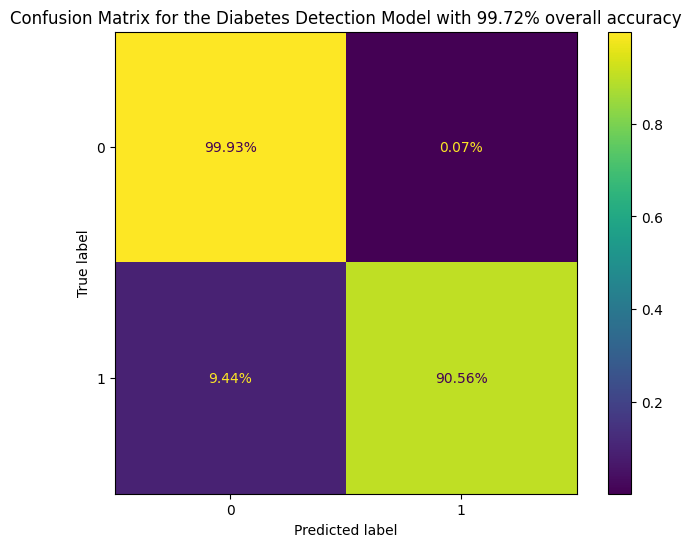

In [4]:
# Plot a confusion matrix to evaluate the model's performance on unseen data
def confusion_plot(y_test, y_pred, model):
    acc = accuracy_score(y_test, y_pred)*100
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for the Diabetes Detection Model with {acc:.2f}% overall accuracy')
    display.plot(ax=ax, values_format='.2%');

confusion_plot(y_test, y_pred, hist_boost_model)

## 4. Model optimization

In [5]:
# Your code here... Use one of the sklearn hyperparameter optimization functions to optimize the model
def get_best_params(model, optimizer):
    hyper_params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_iter': [100, 200, 500, 1000],
        'max_leaf_nodes': [15, 31, 63, 127],
        'l2_regularization': [0.0, 0.1, 1.0, 10.0],
    }

    grid = optimizer(model, hyper_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
    return grid

grid = get_best_params(hist_boost_model, HalvingGridSearchCV)

In [6]:
run_grid = True

if run_grid:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    grid.fit(X_train, y_train)

    print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'l2_regularization': 10.0, 'learning_rate': 0.2, 'max_iter': 100, 'max_leaf_nodes': 127}


In [7]:
optimized_hist_boost_model = HistGradientBoostingClassifier(l2_regularization= 0.1, learning_rate= 0.01, max_iter= 1000, max_leaf_nodes= 15, random_state=42)

X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', optimized_hist_boost_model)

[0.99563179 0.99707753 0.99698456 0.99746992 0.99706718]


In [8]:
def get_predictions(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred) 
    return y_pred, y_test

y_pred, y_test = get_predictions(train_df, test_df, 'incident', optimized_hist_boost_model)

[1 0 0 ... 0 0 0]


## 5. Test-set performance: confusion matrix

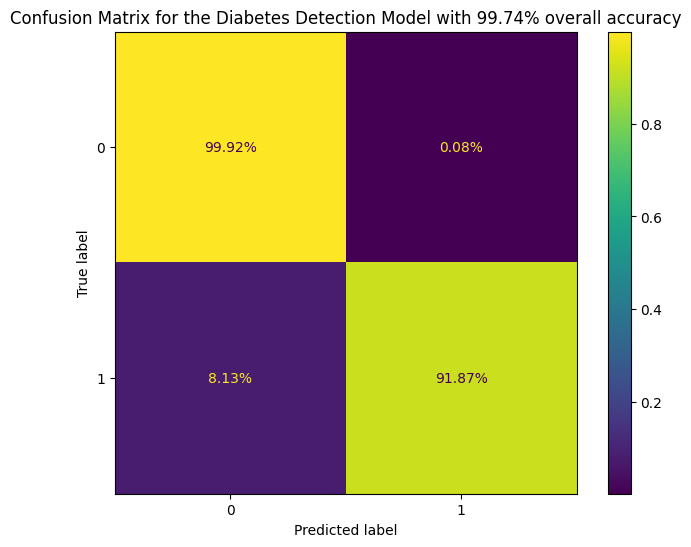

In [9]:
confusion_plot(y_test, y_pred, optimized_hist_boost_model)

## 6. Probability distributions

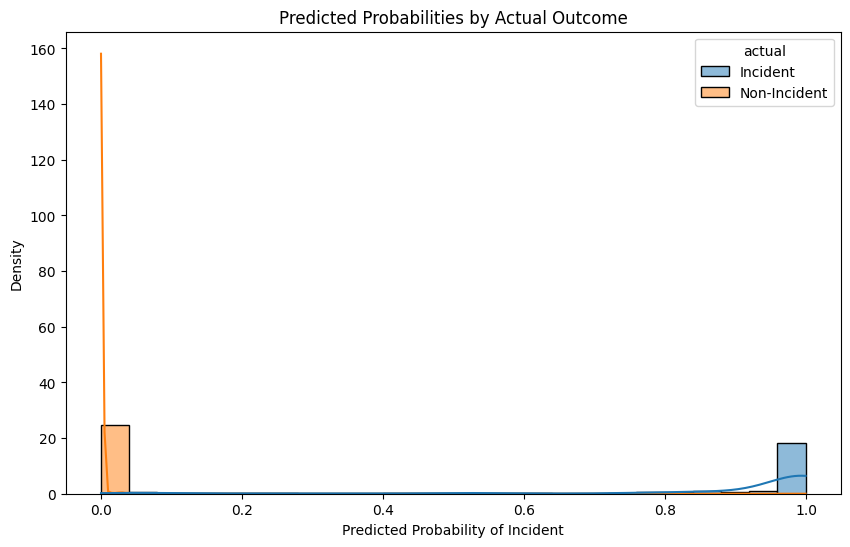

In [10]:
# Your code here... Plot the distributions of predicted probabilities for 
# incidents and non-incidents in the test set. Hint: sklearn has
# model.predict_proba() that returns probabilities rather than class assignments

def probabilities_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    plot_df = pd.DataFrame({
        'probability': prob_incident,
        'actual': y_true.map({0: 'Non-Incident', 1: 'Incident'})
    })

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x='probability', hue='actual', bins=25, kde=True, stat='density', common_norm=False)
    plt.title('Predicted Probabilities by Actual Outcome')
    plt.xlabel('Predicted Probability of Incident')
    plt.ylabel('Density')
    plt.show()

probabilities_plot(optimized_hist_boost_model, test_df)

## 7. Save the optimized model

In [11]:
Path(config.MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)

with open(config.MODEL, 'wb') as output_file:
    pickle.dump(hist_boost_model, output_file)
    pickle.dump(optimized_hist_boost_model, output_file)